# Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("Dataset of Diabetes.csv")

# Data Preprocessing

In [5]:
def val_count(data:pd.Series, orderby:str='Count', ascending:bool=False) -> pd.DataFrame:
    if type(data) == pd.Series:
        result = data.value_counts(dropna=False).reset_index() # without drop
        result.columns = ['Values', 'Count']
        result['%'] = np.around(result['Count'] * 100/len(data), 3)
        return result.sort_values(by=orderby, ascending=ascending)
    else:
        return 'Input Series only'

In [6]:
def numerical_summary(data: pd.Series, n: int = 3) -> pd.Series:
    mean = np.mean(data)
    median = np.median(data)

    std = np.std(data)
    min_value = np.min(data)
    max_value = np.max(data)
    range_value = np.abs(max_value - min_value)
    skewness = data.skew()
    kurtosis = data.kurtosis()

    result = pd.Series([min_value, max_value, range_value, mean, median, std, skewness, kurtosis])
    result.index = ['min','max', 'range','mean','median',  'std','skewness','kurtosis']

    return np.around(result, n)

In [7]:
data.head(5)

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


### Feature Selection

Dikarenakan kolom ID dan No_Pation tidak terlalu berpengaruh terhadap proses pemodelan data, kolom ini dihapus untuk mengurangi kompleksitas dan meminimalkan noise dalam data.

In [8]:
data.drop(['ID','No_Pation'], axis=1, inplace=True)
print(f'Current Column: ({len(data.columns)}):', data.columns.tolist())

Current Column: (12): ['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']


### Penyesuaian Unique Values Pada Kolom *Gender*

In [9]:
dataGender = data.Gender.unique()
print(f"Gender: {dataGender}")

Gender: ['F' 'M' 'f']


In [10]:
data['Gender'] =  data['Gender'].replace({'f': 'F'})

In [11]:
data['Gender'].replace({'F': 0, 'M': 1}, inplace=True)
print('Kolom Gender:', data['Gender'].unique().tolist())

Kolom Gender: [0, 1]


### Penyesuaian Unique Values Pada Kolom *Class*

In [12]:
dataClass = data.CLASS.unique()
print(f"Class: {dataClass}")

Class: ['N' 'N ' 'P' 'Y' 'Y ']


In [13]:
data['CLASS'] =  data['CLASS'].replace({'N ': 'N', 'P': 'Y', 'Y ': 'Y'})

In [14]:
data['CLASS'].replace({'N': 0, 'Y': 1}, inplace=True)
print('Kolom Class:', data['CLASS'].unique().tolist())

Kolom Class: [0, 1]


# Data Cleaning

### Cek Missing Values

In [15]:
data.isna().sum()

Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
CLASS     0
dtype: int64

### Mengatasi Data Duplikat

In [16]:
dataDuplicate = data.duplicated().sum()
dataDuplicate

np.int64(174)

In [17]:
print(f"UKuran data sebelum menghapus duplikat: {data.shape}")

UKuran data sebelum menghapus duplikat: (1000, 12)


In [18]:
data = data.drop_duplicates().reset_index(drop=True)
print(f"UKuran data setelah menghapus duplikat: {data.shape}")

UKuran data setelah menghapus duplikat: (826, 12)


# Exploration Data Analysis

### Kolom Gender

In [19]:
gender = val_count(data.Gender)
gender.style.hide(axis='index')

Values,Count,%
1,463,56.053000
0,363,43.947000


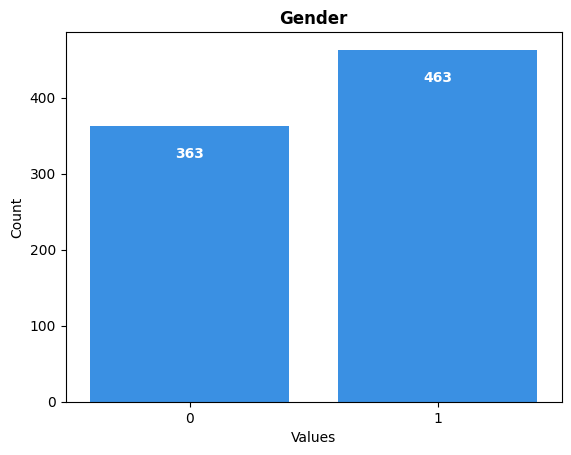

In [20]:
ax = sns.barplot(data=gender, x='Values', y='Count', color='dodgerblue')
ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
plt.title('Gender', fontweight='bold')
plt.show()

### Kolom Age

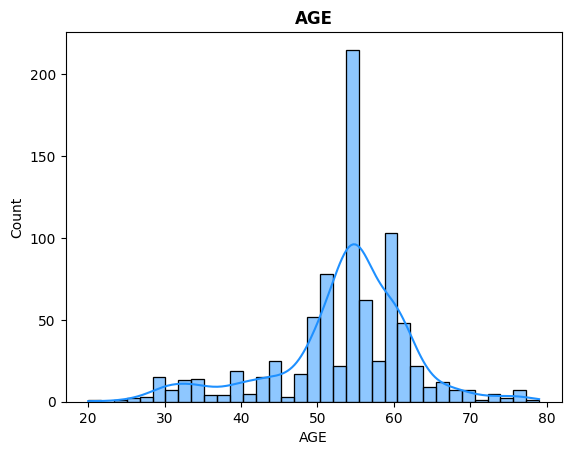

In [21]:
sns.histplot(data['AGE'], kde=True, color='dodgerblue')
plt.title('AGE', fontweight='bold')
plt.show()

In [22]:
numerical_summary(data['AGE'])

min         20.000
max         79.000
range       59.000
mean        53.490
median      55.000
std          8.803
skewness    -0.811
kurtosis     1.446
dtype: float64

### Kolom Urea

In [23]:
data.head()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0


### Kolom Cr

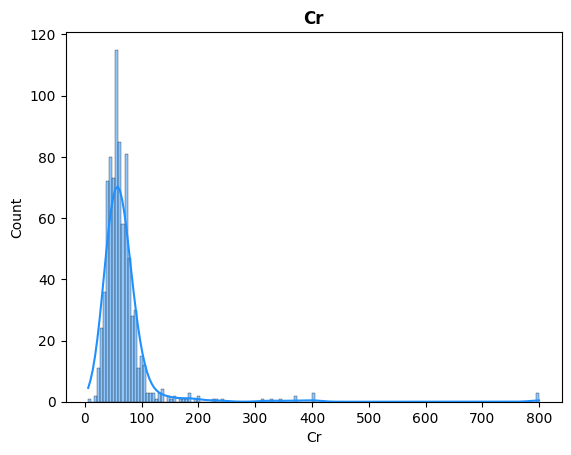

In [24]:
sns.histplot(data['Cr'], kde=True, color='dodgerblue')
plt.title('Cr', fontweight='bold')
plt.show()

### Kolom HbA1c

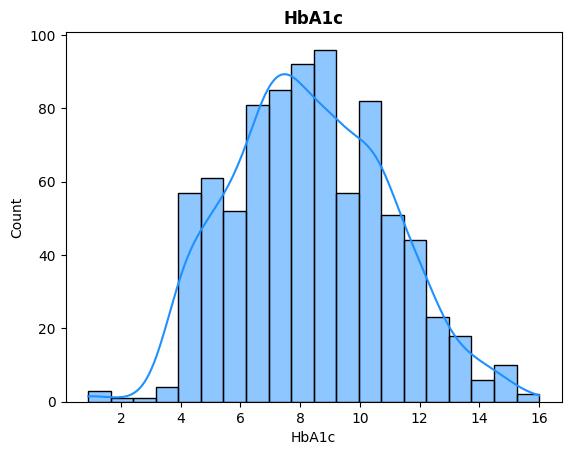

In [25]:
sns.histplot(data['HbA1c'], kde=True, color='dodgerblue')
plt.title('HbA1c', fontweight='bold')
plt.show()

### Kolom Chol

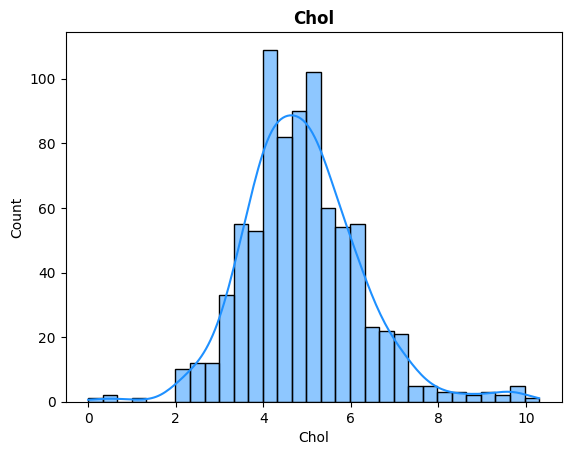

In [26]:
sns.histplot(data['Chol'], kde=True, color='dodgerblue')
plt.title('Chol', fontweight='bold')
plt.show()

### Kolom TG

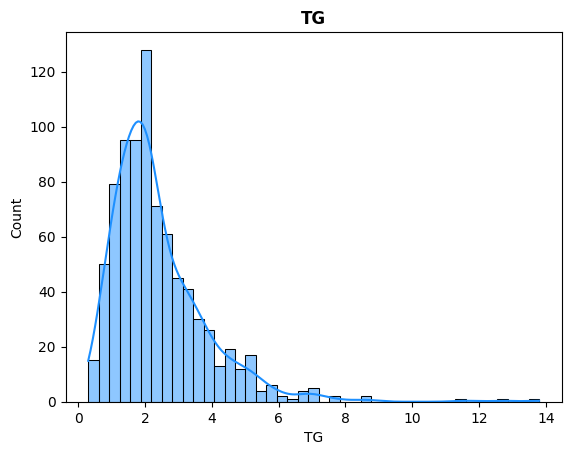

In [27]:
sns.histplot(data['TG'], kde=True, color='dodgerblue')
plt.title('TG', fontweight='bold')
plt.show()

### Kolom HDL

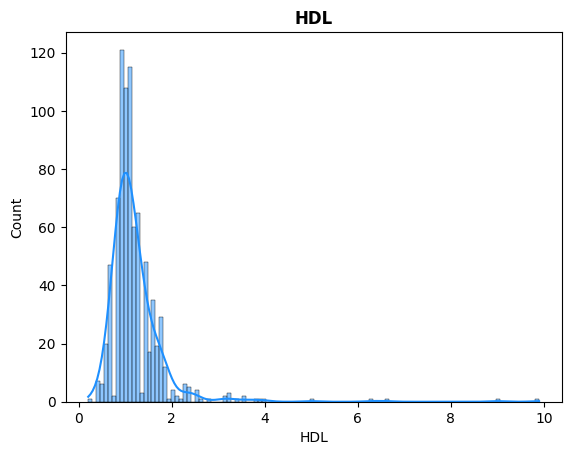

In [28]:
sns.histplot(data['HDL'], kde=True, color='dodgerblue')
plt.title('HDL', fontweight='bold')
plt.show()

### Kolom LDL

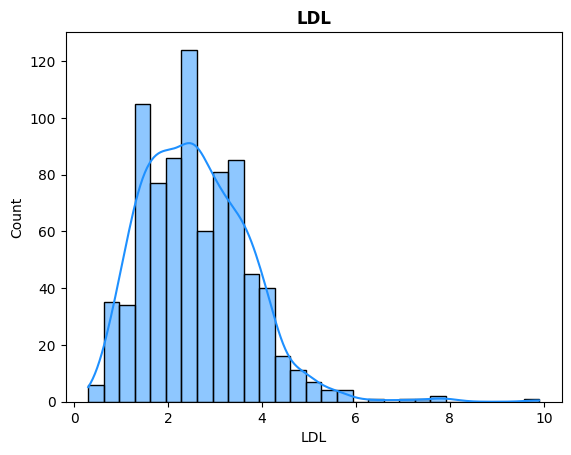

In [29]:
sns.histplot(data['LDL'], kde=True, color='dodgerblue')
plt.title('LDL', fontweight='bold')
plt.show()

### Kolom VLDL

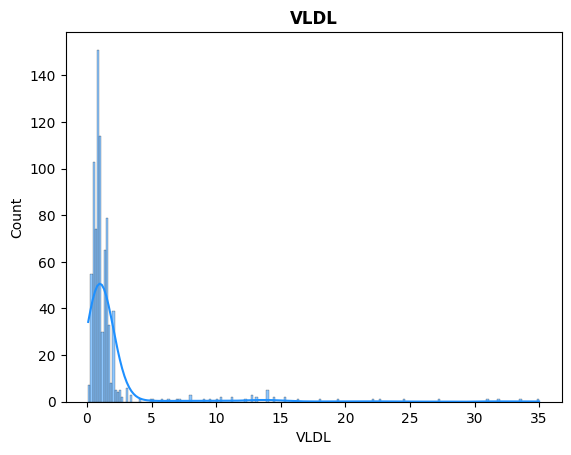

In [30]:
sns.histplot(data['VLDL'], kde=True, color='dodgerblue')
plt.title('VLDL', fontweight='bold')
plt.show()

### Kolom BMI

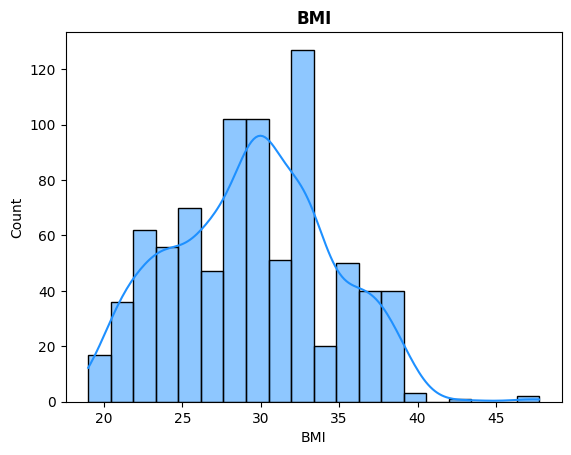

In [31]:
sns.histplot(data['BMI'], kde=True, color='dodgerblue')
plt.title('BMI', fontweight='bold')
plt.show()

### Correlation Matrix

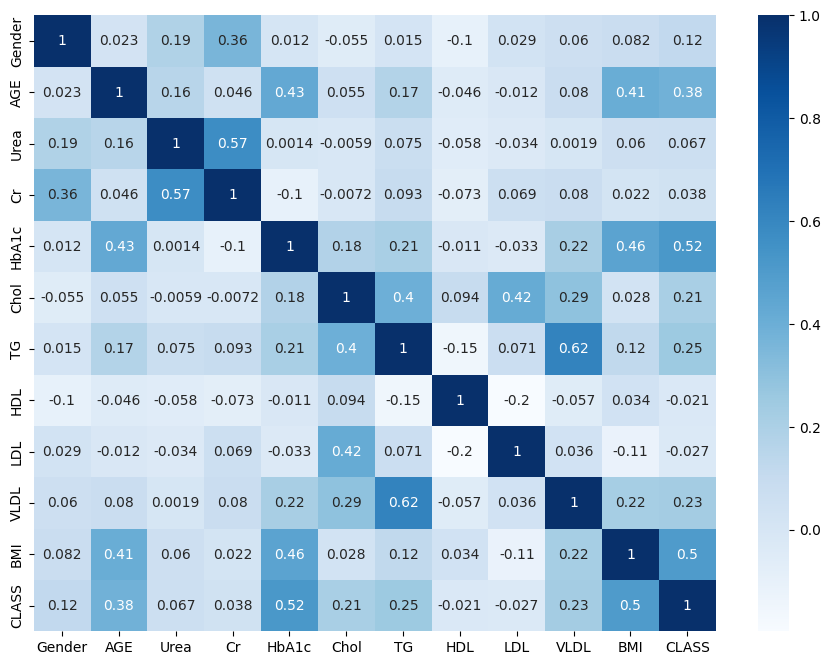

In [32]:
plt.figure(figsize=(11,8))
sns.heatmap(data.corr(method='spearman'), annot=True, cmap='Blues')
plt.show()

In [33]:
corr_with_target = data.drop('CLASS', axis=1).corrwith(data['CLASS'],axis=0, method='spearman')
corr_with_target = corr_with_target.sort_values(key=abs, ascending=False).reset_index()
corr_with_target = corr_with_target.rename(columns={'index':'Feature', 0:'Corr'})
print('Sorted Correlation Between Feature and Target(CLASS)\n')
display(corr_with_target.style.hide(axis='index'))

Sorted Correlation Between Feature and Target(CLASS)



Feature,Corr
HbA1c,0.521619
BMI,0.502826
AGE,0.383285
TG,0.253221
VLDL,0.231634
Chol,0.212505
Gender,0.120338
Urea,0.067122
Cr,0.038377
LDL,-0.026866


# Identifikasi Outlier

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  826 non-null    int64  
 1   AGE     826 non-null    int64  
 2   Urea    826 non-null    float64
 3   Cr      826 non-null    int64  
 4   HbA1c   826 non-null    float64
 5   Chol    826 non-null    float64
 6   TG      826 non-null    float64
 7   HDL     826 non-null    float64
 8   LDL     826 non-null    float64
 9   VLDL    826 non-null    float64
 10  BMI     826 non-null    float64
 11  CLASS   826 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 77.6 KB


In [35]:
data.head(5)

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0
3,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,0
4,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,0


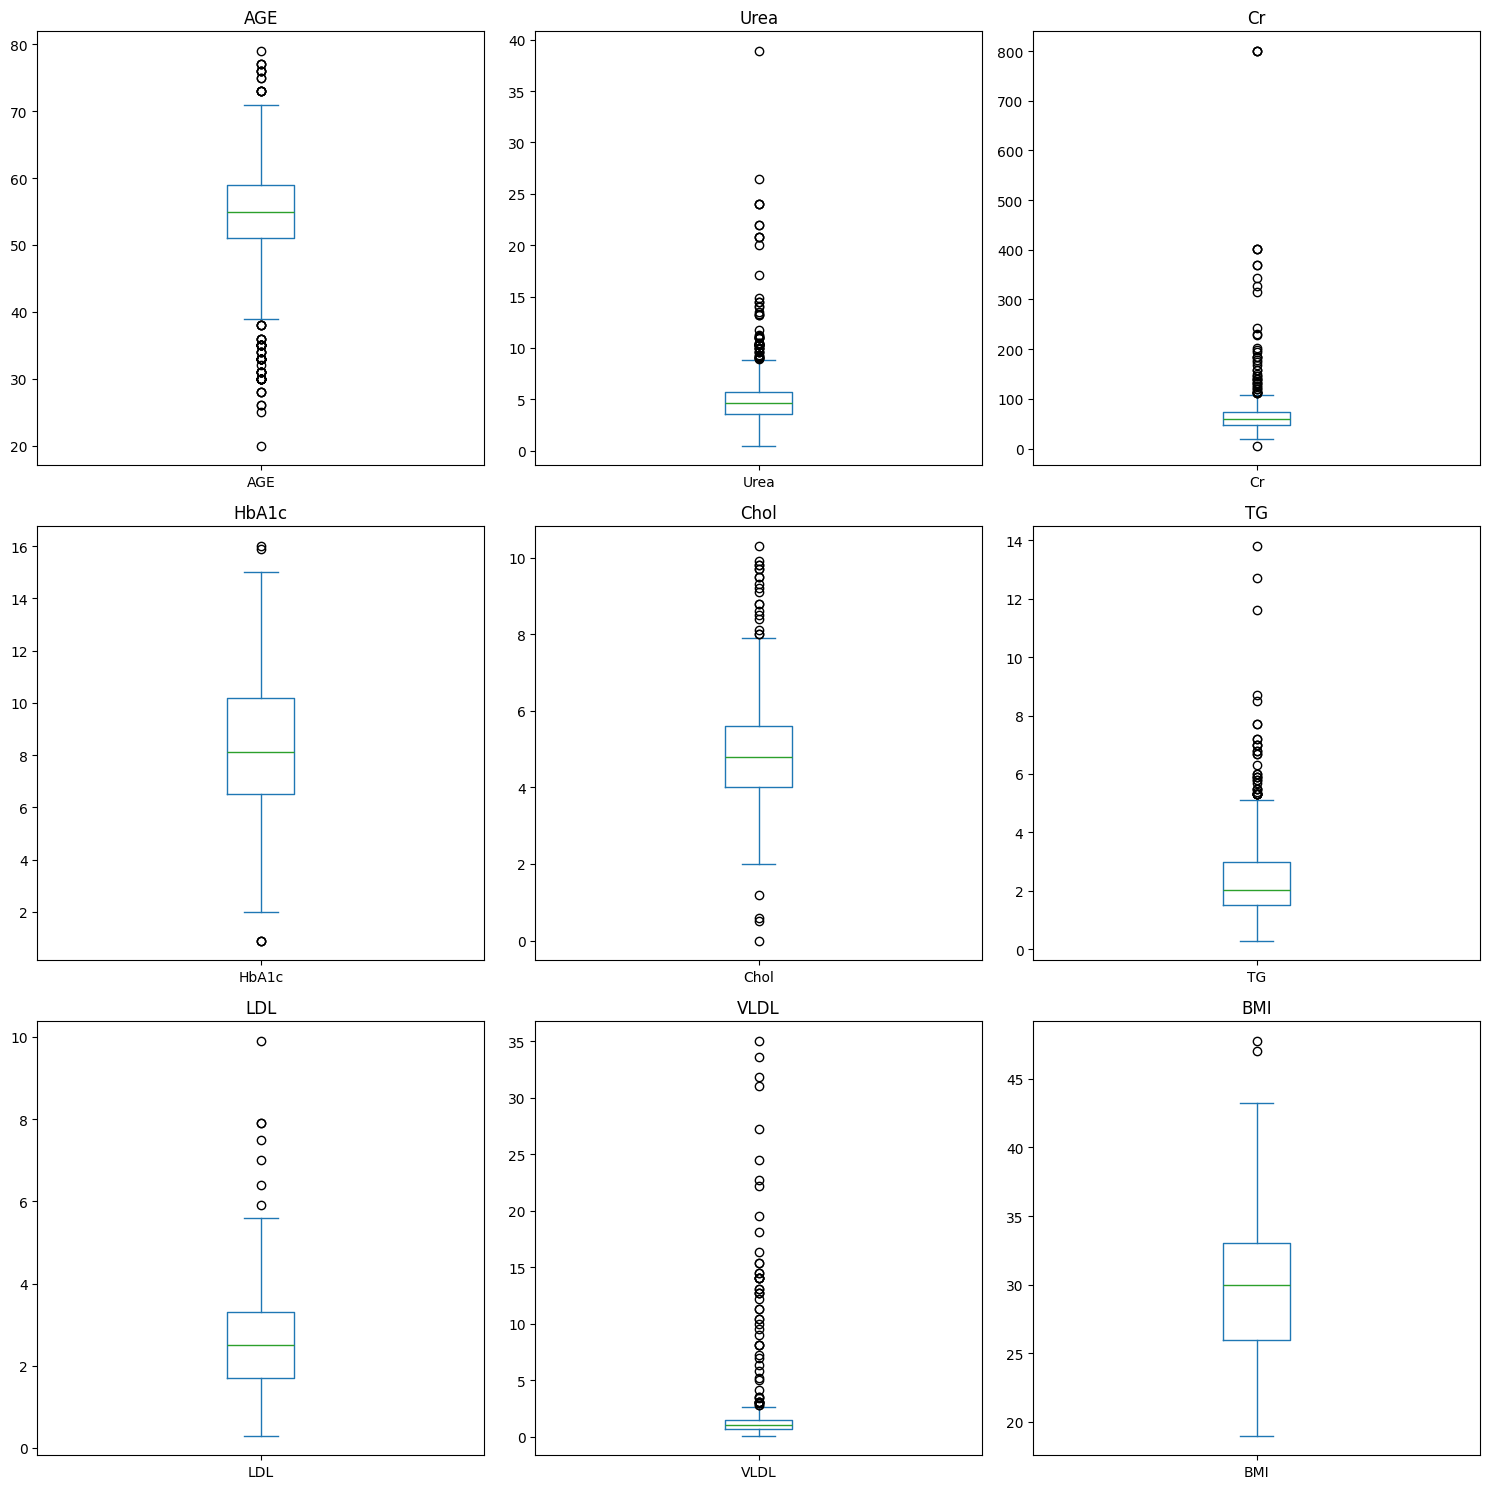

In [36]:
ratio_data = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'LDL', 'VLDL', 'BMI']

n_cols = 3
n_rows = int(np.ceil(len(ratio_data) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

for i, col in enumerate(ratio_data):
    row = i // n_cols
    col_num = i % n_cols

    data[col].plot(kind='box', ax=axes[row, col_num])
    axes[row, col_num].set_title(col)

for j in range(len(ratio_data), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [37]:
def cek_outlier(nama_kolom, batas):
  Q1 = np.percentile(data[nama_kolom], 25,
                     interpolation = 'midpoint')

  Q3 = np.percentile(data[nama_kolom], 75,
                     interpolation = 'midpoint')

  IQR = Q3 - Q1

  if batas == 'upper_bound':
      bound = np.where(data[nama_kolom] >= (Q3 + 1.5 * IQR))
  elif batas == 'lower_bound':
      bound = np.where(data[nama_kolom] <= (Q1 - 1.5 * IQR))
  return list(bound[0])

In [38]:
ratio_data = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'LDL', 'VLDL', 'BMI']

total_data = len(data)

for col in ratio_data:
    upper_outliers = cek_outlier(col, 'upper_bound')
    lower_outliers = cek_outlier(col, 'lower_bound')
    total_outliers = len(upper_outliers) + len(lower_outliers)
    
    percentage_outliers = (total_outliers / total_data) * 100
    
    print(f"Kolom {col}: {percentage_outliers:.2f}% data merupakan outlier ({total_outliers}/{total_data})")


Kolom AGE: 10.65% data merupakan outlier (88/826)
Kolom Urea: 6.90% data merupakan outlier (57/826)
Kolom Cr: 5.57% data merupakan outlier (46/826)
Kolom HbA1c: 0.61% data merupakan outlier (5/826)
Kolom Chol: 2.78% data merupakan outlier (23/826)
Kolom TG: 4.36% data merupakan outlier (36/826)
Kolom LDL: 0.85% data merupakan outlier (7/826)
Kolom VLDL: 6.54% data merupakan outlier (54/826)
Kolom BMI: 0.24% data merupakan outlier (2/826)


### Data Sesudah Outlier Dihapus

In [40]:
cleaned_data = data.copy()

for col in ratio_data:
    upper_outliers = cek_outlier(col, 'upper_bound')
    lower_outliers = cek_outlier(col, 'lower_bound')
    
    all_outliers = list(set(upper_outliers + lower_outliers))
    
    cleaned_data = cleaned_data.drop(index=[idx for idx in all_outliers if idx in cleaned_data.index])

cleaned_data.reset_index(drop=True, inplace=True)

print(f"Data setelah penghapusan outlier: {len(cleaned_data)} baris dari awalnya {len(data)} baris.")


Data setelah penghapusan outlier: 603 baris dari awalnya 826 baris.


# Feature Engineering

### Normalisasi Data

In [41]:
norm_col = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(cleaned_data[norm_col])
data_scaled = pd.DataFrame(data_scaled, columns=norm_col)
cleaned_data = pd.concat([data_scaled, cleaned_data[['Gender', 'CLASS']]], axis=1)

In [42]:
cleaned_data.head(5)

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Gender,CLASS
0,0.333333,0.467532,0.285714,0.223077,0.372881,0.125000,0.226804,0.207547,0.16,0.25,0,0
1,0.166667,0.155844,0.023810,0.153846,0.152542,0.145833,0.082474,0.226415,0.12,0.10,0,0
2,0.333333,0.116883,0.333333,0.153846,0.271186,0.208333,0.072165,0.339623,0.20,0.25,0,0
3,0.266667,0.467532,0.297619,0.153846,0.152542,0.104167,0.072165,0.245283,0.12,0.25,1,0
4,0.100000,0.194805,0.535714,0.153846,0.305085,0.125000,0.226804,0.641509,0.36,0.10,1,0


### Cek Kolom Class

In [43]:
class_ = val_count(cleaned_data.CLASS)
class_.style.hide(axis='index')

Values,Count,%
1,545,90.381000
0,58,9.619000


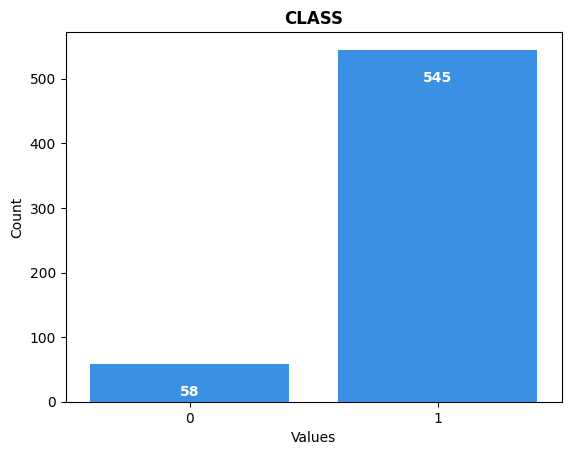

In [44]:
ax = sns.barplot(data=class_, x='Values', y='Count', color='dodgerblue')
ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
plt.title('CLASS', fontweight='bold')
plt.show()

### Train test split

In [45]:
X = cleaned_data.drop('CLASS', axis=1)
y = cleaned_data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print('Jumlah Baris Data Latih:', len(X_train))
print('Jumlah Baris Data Uji:', len(X_test))

Jumlah Baris Data Latih: 482
Jumlah Baris Data Uji: 121


### Menyeimbangkan Kolom Class 

In [46]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

sampler_count = [['Original Data', y_train], ['SMOTE', y_SMOTE]]

for i in sampler_count:
    print(i[0])
    display(val_count(pd.Series(i[1])))

Original Data


,Values,Count,%
0,1,436,90.456
1,0,46,9.544


SMOTE


,Values,Count,%
0,1,436,66.667
1,0,218,33.333


# Data Modelling

In [47]:
resample = [
    ('Original', X_train, y_train),
    ('SMOTE', X_SMOTE, y_SMOTE)
]

models = [
    ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski')),
]

results = []

for r_name, X, y in resample:
    for m_name, model in models:
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append((r_name+' - '+m_name, accuracy, precision, recall, f1))

# Evaluation

In [48]:
comparison = pd.DataFrame(results, columns=['Model', 'Accuracy','Precision','Recall', 'F1 Score'])
comparison = comparison.set_index(['Model'])
comparison.index.name = None

comparison.reindex(comparison.mean(axis=1).sort_values(ascending=False).index)

,Accuracy,Precision,Recall,F1 Score
Original - KNN,0.92562,0.938596,0.981651,0.959641
SMOTE - KNN,0.92562,0.971698,0.944954,0.958140
